### Copyright 2025 Edward Späth, Frankfurt University of Applied Sciences, FB2, Computer Science
### No liability or warranty; only for educational and non-commercial purposes
### See some basic hints for working with Jupyter notebooks in README.md

## Knapsack Problem

### Imports

In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib as mpl
import math
import numpy as np
from copy import deepcopy

### Configuration

In [2]:
GRID_COLOR = "BLACK"
FIGURE_MARGIN = 0.1
# With this you can configure which kind of colors each item gets.
# For this, a color gradient (colormap) is used.
# Please see here to find all the available colormaps:
# https://matplotlib.org/stable/gallery/color/colormap_reference.html
# I recommend not picking one, which has white in its gradient.
KNAPSACK_COLORMAP_NAME = "gist_rainbow"
# If enabled, one cell will not always correspond to one unit, but scale according to size.
# For example, by having each cell represent two units.
ALLOW_SCALE_UNITS = True
BASE_GRID_WIDTH = 5
LEGEND_FONTSIZE = 16
LEGEND_LINE_SPACING = 1
GAP_AFTER_LEGEND = 0.05

### Class representing items

In [3]:
class Item:
    def __init__(self, weight, value):
        self.weight = weight
        self.value = value
        self.value_per_weight = self.value / self.weight
        self.weight_used = weight
        self.value_used = value
        self._color = None

    def __repr__(self):
        return f"Item({self.weight}, {self.value})"

    def format_to_legend(self, show_total=False):
        display_value = format_int_float_dynamically(self.value_used if not show_total else self.value)
        display_weight = format_int_float_dynamically(self.weight_used if not show_total else self.weight)
        return f"Value: {display_value}\nWeight: {display_weight}"


def format_int_float_dynamically(number):
    # Idea: If number is close to an integer (at least within two decimal places),
    # then display it as an integer, otherwise as a float with two decimal places.
    return str(round(number)) if abs(number - round(number)) < 0.001 else f"{number:>.2f}"


def create_items_bulk(*item_iterables):
    return list(map(lambda item_iterable: Item(item_iterable[0], item_iterable[1]), item_iterables))

### Knapsack implementation

In [4]:
def knapsack_01_dyn_prog(max_capacity, objects):
    values = [[0]*(len(objects)+1) for _ in range(max_capacity+1)]
    # try to find a better solution when using the current object ...
    for i in range(1, len(objects)+1):
        # ... for up to capacity
        for capacity in range(1, max_capacity+1):
            values[capacity][i] = values[capacity][i-1]
            if objects[i-1].weight <= capacity and values[capacity-objects[i-1].weight][i-1]+objects[i-1].value > values[capacity][i]:
                values[capacity][i] = values[capacity -
                                             objects[i-1].weight][i-1]+objects[i-1].value

    # find all used objects
    used_objects = []
    capacity = max_capacity
    obj = len(objects)
    while obj > 0:
        if values[capacity][obj] > values[capacity][obj-1]:
            # take this object
            used_objects.insert(0, objects[obj-1])
            capacity -= objects[obj-1].weight
        obj -= 1
    return used_objects

### Knapsack implementation allowing fractional parts

In [5]:
def knapsack_parts(max_capacity, all_objects):
    # internal copy of array with objects that can be destroyed
    objects = all_objects[:]
    # sort objects in decreasing order according value per weight
    objects.sort(key=lambda obj: obj.value_per_weight, reverse=True)
    selected_objects = []
    remaining_capacity = max_capacity
    value = 0
    while (remaining_capacity > 0 and len(objects) > 0):
        if objects[0].weight <= remaining_capacity:
            # take it completely
            selected_objects += [objects[0]]
            remaining_capacity -= objects[0].weight
            objects.pop(0)
        else:
            # use fractional part
            percentage_used = remaining_capacity / objects[0].weight
            # add just fitting fraction
            selected_objects += [objects[0]]
            selected_objects[-1].weight_used = selected_objects[-1].weight * \
                percentage_used
            selected_objects[-1].value_used = selected_objects[-1].value * \
                percentage_used
            # to be safe against rounding errors
            remaining_capacity = 0
        value += selected_objects[-1].value
    return selected_objects

### Helper function for randomness

In [6]:
np.random.seed(0)

def get_random_capacity_and_items(min_capacity, max_capacity, min_item_count, max_item_count, min_item_value, max_item_value, min_item_weight, max_item_weight, allow_fractions):
    if min_capacity > max_capacity:
        print("Minimum and maximum capacity were implicitly swapped.")
        min_capacity, max_capacity = max_capacity, min_capacity
    if min_item_count > max_item_count:
        print("Minimum and maximum item count were implicitly swapped.")
        min_item_count, max_item_count = max_item_count, min_item_count
    if min_item_value > max_item_value:
        print("Minimum and maximum item value were implicitly swapped.")
        min_item_value, max_item_value = max_item_value, min_item_value
    if min_item_weight > max_item_weight:
        print("Minimum and maximum item weight were implicitly swapped.")
        min_item_weight, max_item_weight = max_item_weight, min_item_weight
    capacity = round(np.random.random() *
                     (max_capacity-min_capacity) + min_capacity, 2)
    if not allow_fractions:
        capacity = math.ceil(capacity)
    amount_items = round(np.random.random() *
                     (max_item_count-min_item_count) + min_item_count)
    items = []
    for _ in range(amount_items):
        value = round(np.random.random() * (max_item_value -
                      min_item_value) + min_item_value, 2)
        weight = round(np.random.random() * (max_item_weight -
                       min_item_weight) + min_item_weight, 2)
        if not allow_fractions:
            value = math.ceil(value)
            weight = math.ceil(weight)
        items.append(Item(weight, value))
    return capacity, items

### Visualization

In [7]:

def determine_start_position_and_direction(amount_rows, amount_columns, amount_items):
    start_from_left = amount_rows % 2 == 1 or amount_rows * \
        amount_columns == amount_items
    if start_from_left:
        next_cell = (0, 0)
        horizontal_direction = 1  # 1=go right, -1=go left
    else:
        next_cell = (amount_columns, 0)
        horizontal_direction = -1  # 1=go right, -1=go left
    return next_cell, horizontal_direction


def draw_grid_around_cell(ax, x, y, width=1, height=1, color=GRID_COLOR):
    ax.hlines([y], x, x+width, colors=color)
    ax.hlines([y+height], x, x+width, colors=color)
    ax.vlines([x], y, y+height, colors=color)
    ax.vlines([x+width], y, y+height, colors=color)


def draw_separation_vertical_line(ax, x, y, height=1, color=GRID_COLOR):
    ax.vlines([x], y, y+height, colors=color, linestyles="dotted")


def how_much_can_be_inserted_in_row(next_cell, horizontal_direction, max_x, unit=1):
    next_x, next_y = next_cell
    potential_next_x = next_x + horizontal_direction * unit
    if potential_next_x > max_x:
        can_insert = unit - abs(max_x - potential_next_x)
    elif potential_next_x < 0:
        can_insert = unit - abs(potential_next_x)
    else:
        can_insert = unit
    return can_insert


def insert_cell(next_cell, horizontal_direction, max_x, item, ax, unit=1):
    x, y = next_cell
    width_to_be_inserted = how_much_can_be_inserted_in_row(
        next_cell, horizontal_direction, max_x, unit)
    x_offset = -0.5 * width_to_be_inserted + \
        horizontal_direction/2 * width_to_be_inserted
    ax.add_patch(plt.Rectangle((x + x_offset, y),
                 width_to_be_inserted, 1, facecolor=item._color))
    next_cell, horizontal_direction = get_next_position(
        next_cell, horizontal_direction, max_x, unit=width_to_be_inserted)
    return unit - width_to_be_inserted, next_cell, horizontal_direction


def get_next_position(next_cell, horizontal_direction, max_x, unit=1):
    next_x, next_y = next_cell
    potential_next_x = next_x + horizontal_direction * unit
    next_x = potential_next_x
    if potential_next_x >= max_x:
        next_y += 1
        next_x = max_x
        horizontal_direction = -1
    if potential_next_x <= 0:
        next_y += 1
        next_x = 0
        horizontal_direction = 1
    next_cell = (next_x, next_y)
    return next_cell, horizontal_direction


def create_legend(items, axs, fig, include_empty):
    legend_ax = axs[0]
    legend_ax.axis("off")
    legend_patches = []
    for item in items:
        legend_patch = mpatches.Patch(
            facecolor=item._color, edgecolor=GRID_COLOR, label=item.format_to_legend(show_total=True))
        legend_patches.insert(0, legend_patch)
    if include_empty:
        legend_patches.insert(0, mpatches.Patch(
            facecolor="white", edgecolor=GRID_COLOR, label="Empty"))
    # The idea is to just place all the items in one row.
    # This will likely make the the figure stretch, since the legend would then be longer than the actual containers.
    # But then I can measure the size of the containers and calculate by how much the legend stretches the figure.
    # I can then use that to make sure, that the figure is not stretched by distributing
    # the legend into multiple columns.
    container_bbox = axs[1].get_window_extent(
    ).transformed(fig.transFigure.inverted())
    legend_ax.legend(handles=legend_patches, loc="upper left", ncol=len(
        legend_patches), fontsize=LEGEND_FONTSIZE, labelspacing=LEGEND_LINE_SPACING, frameon=True)
    one_row_legend_bbox = legend_ax.get_legend(
    ).get_window_extent().transformed(fig.transFigure.inverted())
    # It does not matter which container one uses, since both will have the same axis width,
    # which was sychronized before.
    container_bbox = axs[1].get_window_extent(
    ).transformed(fig.transFigure.inverted())
    one_row_legend_x0, one_row_legend_x1 = one_row_legend_bbox.x0, one_row_legend_bbox.x1
    container_x0, container_x1 = container_bbox.x0, container_bbox.x1

    ratio = (container_x1 - container_x0) / \
        (one_row_legend_x1 - one_row_legend_x0)
    # Create as many columns as needed, so that width of image stays similar. Fill each row as full as possible.
    legend_cols = len(legend_patches) * ratio + 2*FIGURE_MARGIN
    legend_ax.legend(handles=legend_patches, loc="upper left", ncol=max(
        1, legend_cols), fontsize=LEGEND_FONTSIZE, labelspacing=LEGEND_LINE_SPACING, frameon=True)
    legend_bbox = axs[0].get_legend().get_window_extent(
    ).transformed(fig.transFigure.inverted())
    legend_y0, legend_y1 = legend_bbox.y0, legend_bbox.y1
    pos = legend_ax.get_position()
    shift_down_by = abs((pos.y1 - pos.y0) - (legend_y1 - legend_y0))
    shift_down_by = abs(legend_y0 - legend_y1)
    for ax in axs[1:]:
        pos = ax.get_position()
        legend_ax.set_position(
            [pos.x0, pos.y0 + pos.y1 + shift_down_by + GAP_AFTER_LEGEND, pos.x1, pos.y1])


def visualize_container(label, capacity, items, visualize_in_2d, ax):
    if not visualize_in_2d and ALLOW_SCALE_UNITS:
        unit_scale = 1 if capacity < 10 else 1 / (capacity // 10)
    else:
        unit_scale = 1
    # No capacity, therefore nothing to visualize
    if capacity <= 0:
        return
    total_value = sum(map(lambda item: item.value_used, items))
    total_weight = sum(map(lambda item: item.weight_used, items))
    # Determine how many rows and columns are required
    amount_columns = capacity * \
        unit_scale if not visualize_in_2d else math.ceil(math.sqrt(capacity))
    amount_rows = 1 if not visualize_in_2d else math.ceil(
        capacity / amount_columns)
    # Determine size of figure and define grid boundaries
    grid_height_to_width_ratio = min(amount_rows/amount_columns, 1)
    # fig.set_size_inches(BASE_GRID_WIDTH, BASE_GRID_WIDTH *
    #                    grid_height_to_width_ratio)
    ax.axis([0 - FIGURE_MARGIN, amount_columns + FIGURE_MARGIN, 0 -
            FIGURE_MARGIN, amount_rows + FIGURE_MARGIN])  # xmin, xmax, ymin, ymax
    ax.apply_aspect()
    # Make sure that X and Y axes are scaled equally
    ax.set_aspect("equal", adjustable="box")
    # Create entire capacity cells
    capacity_units = [1 for full_cell in range(
        math.floor(capacity*unit_scale))]
    fractional_capacity = capacity*unit_scale - math.floor(capacity*unit_scale)
    # Fractional capacity e.g., capacity = 10.5, where 10 full capacity cells are drawn (see above)
    # And then one fractional capacity cell will be drawn (in this example half a cell)
    if fractional_capacity > 0:
        capacity_units.append(fractional_capacity)
    for i, capacity_unit in enumerate(capacity_units):
        column = i % amount_columns
        row = math.floor(i / amount_columns)
        draw_grid_around_cell(ax, column, row, capacity_unit)
    # Determine whether to start filling from right or left
    # to make sure, that the empty space will be in the top right corner
    next_cell, horizontal_direction = determine_start_position_and_direction(
        amount_rows, amount_columns, len(items))
    # Iterate over all items and place them
    for item in items:
        # Draw a separating vertical line to indicate two separate items.
        # Depending on color gradient, adjacent items could have similar colors.
        # This makes them more distinguishable.
        draw_separation_vertical_line(ax, *next_cell)
        # Place one cell for each unit of weight into the grid
        cell_units = [1 for full_cell in range(math.floor(item.weight_used))]
        # In case one item consists not entirely of integers,
        # but instead also a fractional part, then also draw the fractional part.
        # For e.g. weight=4.53 one would first draw the 4 full cells and then the 0.53 fractional cell
        fractional_unit_width = item.weight_used - math.floor(item.weight_used)
        if fractional_unit_width > 0:
            cell_units.append(fractional_unit_width)
        for cell_unit in cell_units:
            leftover_width, next_cell, horizontal_direction = insert_cell(
                next_cell, horizontal_direction, amount_columns, item, ax, unit=cell_unit*unit_scale)
            # Leftover refers to a cell unit not being able to be placed,
            # as it would otherwise be out of bounds on the left or right side.
            if leftover_width > 0:
                _, next_cell, horizontal_direction = insert_cell(
                    next_cell, horizontal_direction, amount_columns, item, ax, unit=leftover_width*unit_scale)
    # Purpose is to eliminate edge cases, where the capacity should be entirely used up,
    # but there is a small piece left due to machine precision.
    # In those cases, the next location to place
    FULL_CAPACITY_EPSILON = 0.0001
    if abs(capacity - total_weight) > FULL_CAPACITY_EPSILON:
        draw_separation_vertical_line(ax, *next_cell)
    ax.set_yticks([])
    amount_of_ticks = math.floor(amount_columns)+1
    ax.set_xticks(range(amount_of_ticks))
    ax.set_xticklabels(
        list(map(lambda xtick: round(xtick / unit_scale), ax.get_xticks())))
    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.tick_params(left=False, bottom=True)
    ax.axis("on")
    ax.set_title(
        label + f"\ntotal value: {format_int_float_dynamically(total_value)}, total weight: {format_int_float_dynamically(total_weight)}", fontsize=18, loc="left")


def visualize_knapsack(capacity, items, allow_fractions=False, show_legend=True, visualize_in_2d=False):
    if not allow_fractions:
        for item in items:
            item.weight = round(item.weight)
            item.value = round(item.value)
            item.value_per_weight = item.value / item.weight
    colors = mpl.colormaps[KNAPSACK_COLORMAP_NAME](
        np.linspace(0, 1, len(items)))
    for item, color in zip(items, colors):
        item._color = color
        item.weight_used = item.weight
        item.value_used = item.value
    if allow_fractions:
        used_items = knapsack_parts(capacity, items)
    else:
        capacity = math.floor(capacity)
        used_items = knapsack_01_dyn_prog(capacity, items)
    unused_items = [item for item in items if item not in used_items]
    if len(used_items) > 0:
        possibly_fractional_item = used_items[-1]
        if allow_fractions:
            if possibly_fractional_item.weight != possibly_fractional_item.weight_used:
                # Item is fractional
                leftover_item_copy = deepcopy(possibly_fractional_item)
                leftover_item_copy.weight_used = leftover_item_copy.weight - \
                    possibly_fractional_item.weight_used
                leftover_item_copy.value_used = leftover_item_copy.value - \
                    possibly_fractional_item.value_used
                unused_items.append(leftover_item_copy)
    fig, axs = plt.subplots(
        3 if show_legend else 2, 1, constrained_layout=True)
    for ax in axs:
        ax.axis("off")

    visualize_container(f"Knapsack (capacity {format_int_float_dynamically(capacity)})",
                        capacity, used_items, visualize_in_2d, axs[-2])
    # Otherwise, there could be slight problems with displaying vertical separation lines
    visualize_container("Items, which did not fit", sum(
        map(lambda item: item.weight_used, unused_items)), unused_items, visualize_in_2d, axs[-1])
    maximum_axis_width = max(map(lambda ax: ax.get_xlim()[-1], axs[-2:]))
    maximum_axis_height = max(map(lambda ax: ax.get_ylim()[-1], axs[-2:]))
    for ax in [axs[-2], axs[-1]]:
        ax.set_xlim(right=maximum_axis_width)
        ax.set_ylim(top=maximum_axis_height)
    if show_legend:
        create_legend(items, axs, fig, include_empty=True)
    plt.show()

### Example

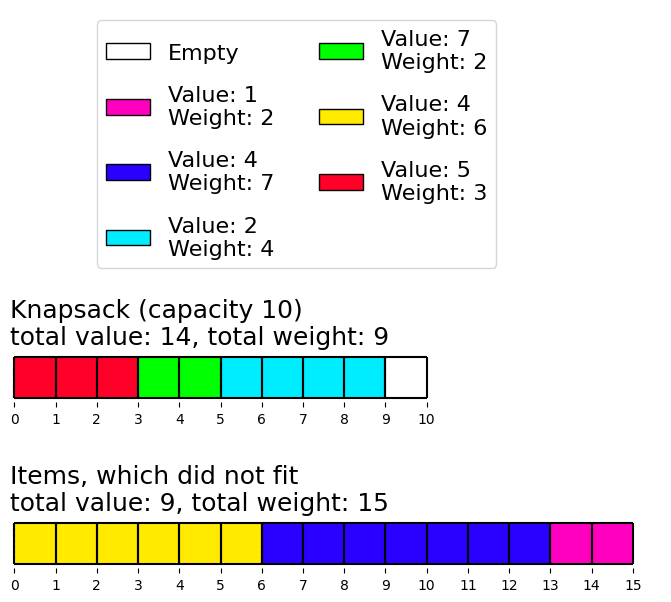

In [8]:
capacity = 10
# Both of the following lines produce the identical result
items = [Item(3, 5), Item(6, 4), Item(2, 7), Item(4, 2), Item(7, 4), Item(2, 1)]
items = create_items_bulk((3, 5), (6, 4), (2, 7), (4, 2), (7, 4), (2, 1))
visualize_knapsack(capacity, items)

### Example with fractional parts

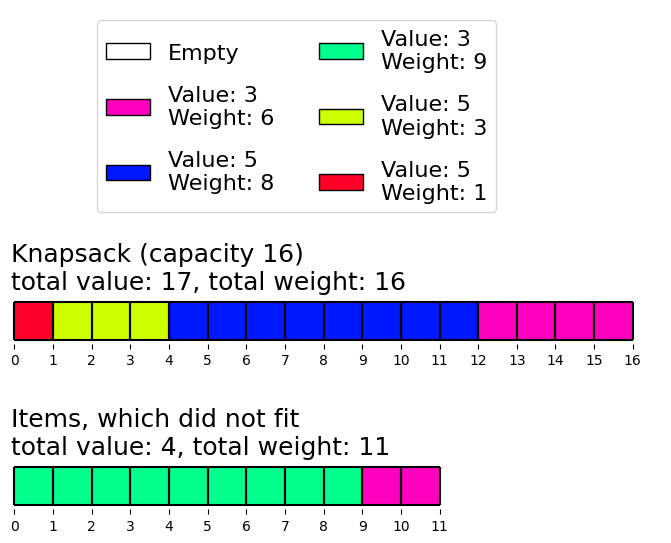

In [9]:
# You can use the "allow_fractions=True" option to allow fractions of parts to be taken.
# This means, that you are allowed to split items in arbitrarily precise parts if they do not fit entirely.
# If only a part of an item is taken, then the part that was taken will be present in the Knapsack
# and the rest of the item, which did not fit anymore, will be shown in the rest.
# Cells of the same color in the knapsack and the rest represent to the same item.
# For instance, the (by default purple) item below has weight 6 and value 3.
# But there is only space for 4/6 of the item. 
# Therefore, 4/6 are in the knapsack and the remaining 2/6 are in the rest. 

items = create_items_bulk((1, 5), (3, 5), (9, 3), (8, 5), (6, 3))
visualize_knapsack(16, items, allow_fractions=True)

### Example with random items and capacity

capacity = 23.23
items = [Item(8.63, 9.44), Item(10.04, 6.93), Item(13.48, 7.13), Item(6.37, 14.49), Item(8.4, 12.08), Item(13.96, 8.95), Item(2.22, 1.99), Item(12.66, 1.28), Item(13.18, 11.89), Item(12.19, 14.7), Item(11.93, 7.46)]


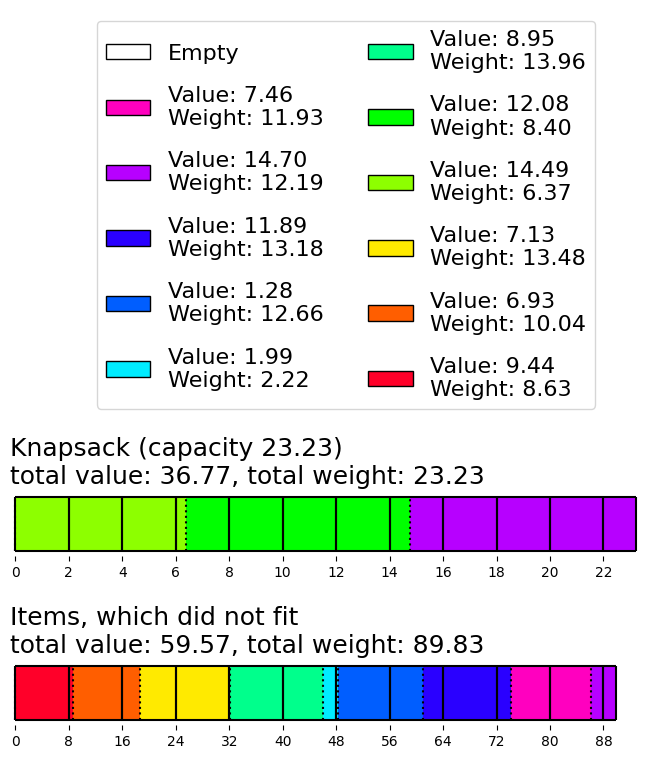

capacity = 16.77
items = [Item(14.23, 3.01), Item(6.81, 8.31), Item(11.84, 4.7), Item(8.96, 7.39), Item(9.65, 1.26), Item(9.64, 9.57), Item(10.55, 14.21), Item(7.12, 6.03), Item(1.84, 10.77), Item(10.39, 10.33)]


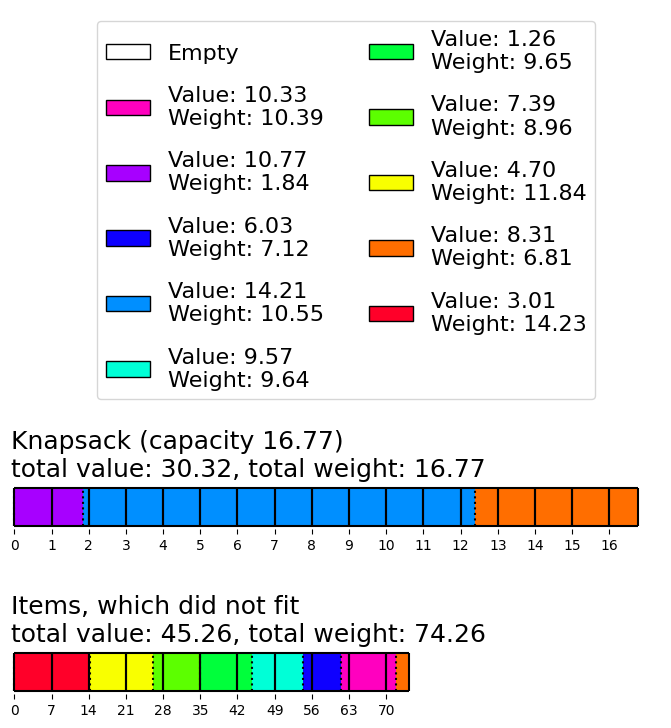

In [10]:
AMOUNT_ITERATIONS = 2
ALLOW_FRACTIONS = True

CAPACITY_MIN = 15
CAPACITY_MAX = 30
ITEM_COUNT_MIN = 1
ITEM_COUNT_MAX = 15
ITEM_VALUE_MIN = 1
ITEM_VALUE_MAX = 15
ITEM_WEIGHT_MIN = 1
ITEM_WEIGHT_MAX = 15

for _ in range(AMOUNT_ITERATIONS):
    capacity, items = get_random_capacity_and_items(
        CAPACITY_MIN, CAPACITY_MAX, ITEM_COUNT_MIN, ITEM_COUNT_MAX, ITEM_VALUE_MIN, ITEM_VALUE_MAX, ITEM_WEIGHT_MIN, ITEM_WEIGHT_MAX, ALLOW_FRACTIONS)
    print("capacity =", capacity)
    print("items =", items)
    visualize_knapsack(capacity, items, allow_fractions=True)

## Other Visualization Method

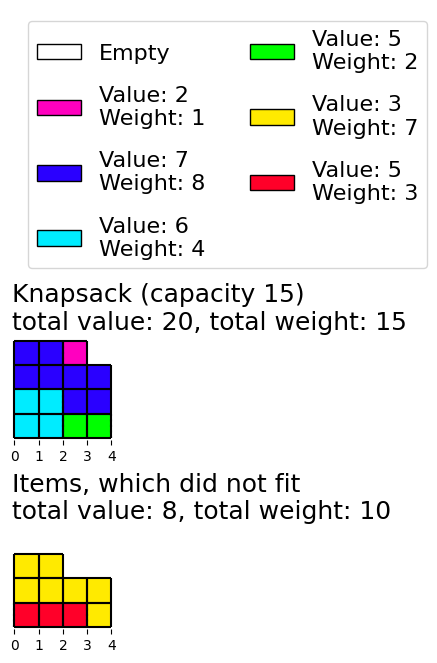

In [11]:
# You may also visualize the knapsack in 2D.
# Please note, that the 2D representation is purely visual.
# The algorithm itself works in one dimension. 
# The 2D representation is only for using space more efficiently in the visualization.

capacity = 15
items = create_items_bulk((3, 5), (7, 3), (2, 5), (4, 6), (8, 7), (1, 2))
visualize_knapsack(capacity, items, allow_fractions=False, show_legend=True, visualize_in_2d=True)

### Your tests go here...

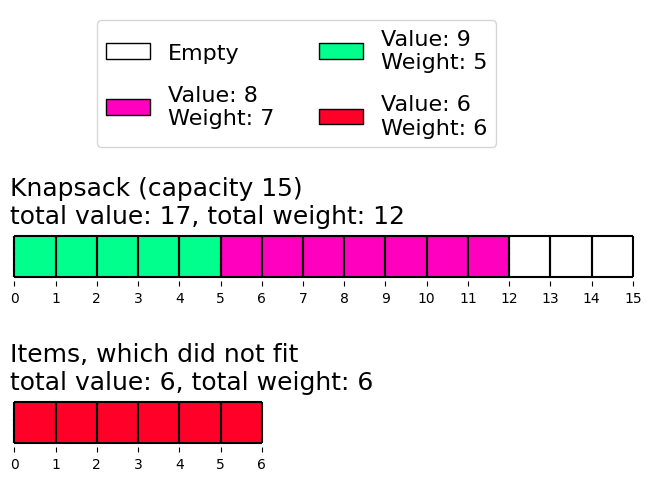

In [12]:
capacity = 15
items = [Item(6, 6), Item(5, 9), Item(7, 8)]

visualize_knapsack(capacity, items, allow_fractions=False, show_legend=True, visualize_in_2d=False)